In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models
import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
# Set parameters
batch_size = 32  # Reduced batch size since medical images might be larger
num_epochs = 15  # Increased epochs since medical classification can be more complex
learning_rate = 1e-4
start_epoch = 0
best_valid_acc = 0
data_set_root = "data"  # Change this to your data directory path
image_size = 224  # Standard size for most pretrained models
save_checkpoint = True
start_from_checkpoint = False
save_dir = 'Models'
model_name = 'Res_18_BrainTumor'

In [5]:
# Set device
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
# Data transforms
# For medical imaging, we want to be careful with augmentations
# Some rotations and flips might be appropriate, but not too extreme
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Slight rotation is usually ok for medical images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# For validation and testing, we only resize and normalize (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# Create datasets using ImageFolder since you have subfolders for each class
data_set_root = "/home/jack/Documents/work/git/DL-TumourClassification/data"  
train_data_path = os.path.join(data_set_root, 'Training')
test_data_path = os.path.join(data_set_root, 'Testing') 

In [15]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)

In [ ]:
# Split training data into train and validation
validation_split = 0.8  # 80% training, 20% validation
n_train_examples = int(len(train_dataset) * validation_split)
n_valid_examples = len(train_dataset) - n_train_examples

In [ ]:
# Use random_split to create the train/validation split
train_data, valid_data = torch.utils.data.random_split(
    train_dataset, 
    [n_train_examples, n_valid_examples],
    generator=torch.Generator().manual_seed(42)  # For reproducible results
)

In [ ]:
# Create data loaders
train_loader = dataloader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = dataloader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# Print dataset information
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

# Print class names
class_names = train_dataset.classes
print(f'Classes: {class_names}')

Number of training examples: 4569
Number of validation examples: 1143
Number of testing examples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Function to normalize images for visualization
def normalize_img(img):
    mins = img.min(0, keepdims=True).min(1, keepdims=True)
    maxs = img.max(0, keepdims=True).max(1, keepdims=True)
    return (img - mins) / (maxs - mins)

Classes shown: ['glioma', 'glioma', 'glioma', 'pituitary', 'pituitary', 'meningioma', 'notumor', 'notumor']


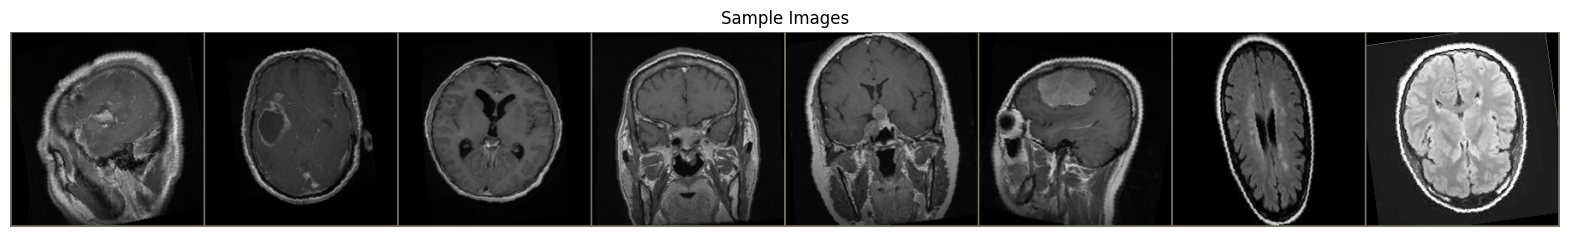

In [ ]:
# Visualize some sample images
def visualize_samples(loader):
    plt.figure(figsize=(20, 10))
    images, labels = next(iter(loader))
    out = torchvision.utils.make_grid(images[0:8])
    plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))
    
    # Print labels with class names
    label_names = [class_names[labels[i]] for i in range(8)]
    print("Classes shown:", label_names)
    
    plt.title("Sample Images")
    plt.axis('off')
    plt.show()

# Call the visualization function
visualize_samples(train_loader)

In [ ]:
# Create the pretrained ResNet model
# Using ResNet18 which is a good balance of accuracy and speed for transfer learning
model = models.resnet18(pretrained=True).to(device)

/home/jack/anaconda3/envs/brats/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jack/anaconda3/envs/brats/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jack/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.14MB/s]


In [ ]:
# Option to freeze some layers
# Initially set to train all layers (no freezing)
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# Replace the final fully connected layer
# ResNet18's last layer outputs 1000 classes (ImageNet)
# We need to change it to 4 classes for tumor classification problem
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)).to(device)

In [ ]:
# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Loss function for multi-class classification
loss_fun = nn.CrossEntropyLoss()

In [ ]:
# Checkpoint handling
save_path = os.path.join(save_dir, model_name + ".pt")

In [28]:
# Create save directory if it doesn't exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [29]:
# Load checkpoint if requested
if start_from_checkpoint:
    if os.path.isfile(save_path):
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_valid_acc = checkpoint['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        raise ValueError("Checkpoint does not exist")
else:
    if os.path.isfile(save_path):
        print("Warning: Checkpoint exists but not loading it.")
    else:
        print("Starting from scratch")



Starting from scratch


In [30]:
# Accuracy calculation
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float() / preds.shape[0]
    return acc

In [32]:
# Training function
def train(net, device, loader, optimizer, loss_fun, loss_logger):
    epoch_loss = 0
    epoch_acc = 0
    
    net.train()
    
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        
        fx = net(x)
        loss = loss_fun(fx, y)
        acc = calculate_accuracy(fx, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_logger.append(loss.item())
        
        clear_output(wait=True)
        print(f"TRAINING: | Iteration [{i+1}/{len(loader)}] | Loss {loss.item():.4f} | Batch Acc {acc.item()*100:.2f}% |")
    
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger


In [33]:
# Evaluation function
def evaluate(net, device, loader, loss_fun, loss_logger=None):
    epoch_loss = 0
    epoch_acc = 0
    
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)
            
            fx = net(x)
            loss = loss_fun(fx, y)
            acc = calculate_accuracy(fx, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            if loss_logger is not None:
                loss_logger.append(loss.item())
            
            clear_output(wait=True)
            print(f"EVALUATION: | Iteration [{i+1}/{len(loader)}] | Loss {loss.item():.4f} | Accuracy {100*(epoch_acc/(i+1)):.2f}% |")
    
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

In [34]:
# Learning rate scheduler - linear decay
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch) / epoch_max) * lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

In [35]:
# Training loop
training_loss_logger = []
validation_loss_logger = []
train_acc_history = []
valid_acc_history = []

# Start training
start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    # Apply learning rate decay
    lr_linear_decay(num_epochs, epoch, learning_rate)
    
    # Train
    train_loss, train_acc, training_loss_logger = train(model, device, train_loader, optimizer, loss_fun, training_loss_logger)
    train_acc_history.append(train_acc * 100)
    
    # Validate
    valid_loss, valid_acc, validation_loss_logger = evaluate(model, device, valid_loader, loss_fun, validation_loss_logger)
    valid_acc_history.append(valid_acc * 100)
    
    # Save checkpoint if validation accuracy improves
    if (valid_acc > best_valid_acc) and save_checkpoint:
        best_valid_acc = valid_acc
        print("Saving Model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'valid_acc': valid_acc,
        }, save_path)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.4f} | Val. Acc: {valid_acc*100:05.2f}% |')

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")



EVALUATION: | Iteration [36/36] | Loss 0.0020 | Accuracy 99.05% |
| Epoch: 15 | Train Loss: 0.0032 | Train Acc: 99.91% | Val. Loss: 0.0364 | Val. Acc: 99.05% |
Training time: 369.50 seconds (6.16 minutes)


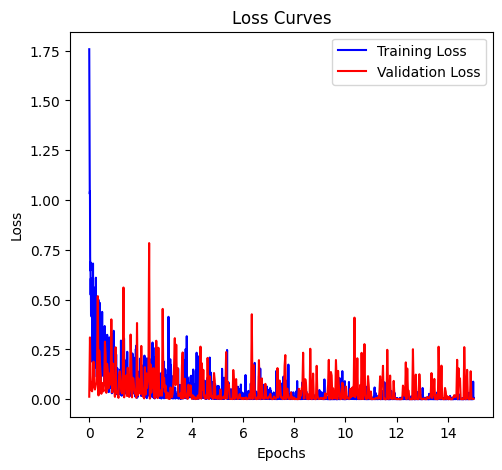

In [36]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, 'b-')
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, 'r-')
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])



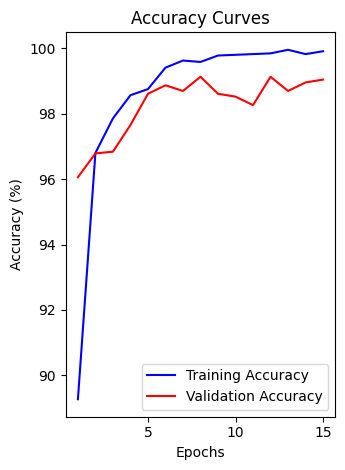

In [37]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs[:len(train_acc_history)], train_acc_history, 'b-')
plt.plot(epochs[:len(valid_acc_history)], valid_acc_history, 'r-')
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.tight_layout()
plt.show()


In [ ]:
# Load the best model for evaluation
if os.path.isfile(save_path):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model with validation accuracy: {checkpoint['valid_acc']*100:.2f}%")

Loaded best model with validation accuracy: 99.13%


In [39]:
# Evaluate on test set
test_loss, test_acc, _ = evaluate(model, device, test_loader, loss_fun)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")


EVALUATION: | Iteration [41/41] | Loss 0.0079 | Accuracy 99.39% |

Test Loss: 0.0263 | Test Accuracy: 99.39%
